In [1]:
import edoxrd as xrd
import peakutils as pk
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
from imp import reload

%matplotlib inline 

In [2]:
d = "/users/zatterin/Documents/data/XRD/2018/e18015/"
files = !ls {d} | grep ras | grep t2t
for index, fname in enumerate(files): print('{0}...{1}'.format(index,fname))

0...e18015_001_t2t.ras
1...e18015_002_t2t.ras


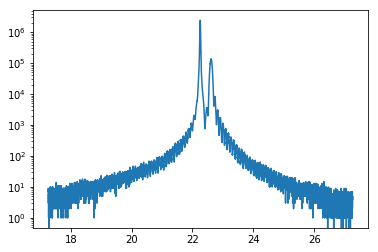

In [3]:
tt, i = xrd.read_data(d+files[0])

plt.plot(tt,i)
plt.yscale('log')

In [4]:
# Def a str fac eqn that accepts any q orientation... TO IMPROVE
def calc_str_fac(material, ttheta):

    # Initialise
    mat_param, mat_pos = xrd.mat_dict()
    q = xrd.tt2q(ttheta)

    # components if q111
    qx = q/np.sqrt(3)
    qy = q/np.sqrt(3)
    qz = q/np.sqrt(3)

    f = xrd.asf(q)

    ls = dict(
        STO = (['Sr', 'Ti'] + ['O']*3),
        PTO = (['Pb', 'Ti'] + ['O']*3),
        MTO = (['Mn', 'Ti'] + ['O']*3),
        SRO = (['Sr', 'Ti'] + ['O']*3),
        KTO = (['K', 'Ta'] + ['O']*3),
        DSO = (['Dy', 'Sc'] + ['O']*3)
            )

    if material == 'SRO_b' or material == 'SRO_t':
        atom_list = ls['SRO']
    else:
        atom_list = ls[material]

    F = 0
    for i, atom in enumerate(atom_list):
        F += f[atom] * np.exp(1j * ( qx * mat_pos[material][i,0]*mat_param[material][0] \
                                 +  qy * mat_pos[material][i,1]*mat_param[material][1] \
                                 +  qz * mat_pos[material][i,2]*mat_param[material][2]))

    return F

Check that this Str Fac is different from the one that assumes a q001:

/users/zatterin/Envs/py3/lib/python3.5/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


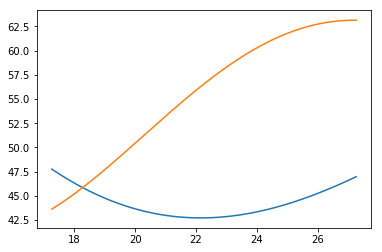

In [7]:
ttheta = np.linspace(0,90,1000)
x = xrd.tt2q(tt)

plt.plot(tt, xrd.calc_str_fac('PTO',tt)) # 001
plt.plot(tt, calc_str_fac('PTO',tt)) # 111

In [12]:
# Initialise
mat_param, mat_pos = mat_dict()
q = tt2q(ttheta)
f = asf(q)

ls = dict(
    STO = (['Sr', 'Ti'] + ['O']*3),
    PTO = (['Pb', 'Ti'] + ['O']*3),
    MTO = (['Mn', 'Ti'] + ['O']*3),
    SRO = (['Sr', 'Ti'] + ['O']*3),
    KTO = (['K', 'Ta']  + ['O']*3),
    DSO = (['Dy', 'Sc'] + ['O']*3)
        )

if material == 'SRO_b' or material == 'SRO_t':
    atom_list = ls['SRO']
else:
    atom_list = ls[material]

F = 0
for i, atom in enumerate(atom_list):
    F += f[atom] * np.exp(1j * ( q * mat_pos[material][i,2]*mat_param[material][2]))

KeyError: 'PTO'

How do you calc the scatt amp for any q? Must you change the lattice fun? (See other .ipynb)

In [8]:
fname = "e16123a_01_t2t_001.ras"
comm = '*'
sub = 'STO'
film = 'PTO'
Nsub = 1e4
Nfilm = 100
c_film = 3.9
scale = 1e2

# Constants
wave = 1.5406
mu = 4e4
param, pos = xrd.mat_dict()
c_sub = param[sub][2]

# Read the data
xdata, ydata = xrd.read_data(fname, d, comments=comm)
q = xrd.tt2q(xdata)

# components if q111
qx = q/np.sqrt(3)
qy = q/np.sqrt(3)
qz = q/np.sqrt(3)

# Load data
mats = [sub,film]#, film]
t = (Nsub*c_sub + Nfilm*c_film)

# Calc structure factor and build shape function dictionary
F = {}
for material in mats:
    F[material] = calc_str_fac(material, xdata) # does not want q, fix?
    S_x = {sub:0, film:0}
    S_y = {sub:0, film:0}
    S_z = {sub:0, film:0}
# Calc shape function for each material
for l in range(0, int(Nsub)):
    S_x[sub] += np.exp(1j*qx*l*param['STO'][0])*np.exp(-l*4e-4)
    S_y[sub] += np.exp(1j*qy*l*param['STO'][1])*np.exp(-l*4e-4)
    S_z[sub] += np.exp(1j*qz*l*param['STO'][2])*np.exp(-l*4e-4)
#     S_x[sub] += np.exp((t-l*mat_param['STO'][0]) * (1j*qx-(4*np.pi)/(mu*wave*qx)))
#     S_y[sub] += np.exp((t-l*mat_param['STO'][1]) * (1j*qy-(4*np.pi)/(mu*wave*qy)))
#     S_z[sub] += np.exp((t-l*c_sub) * (1j*qz-(4*np.pi)/(mu*wave*qz)))
    
for l in range(0, int(Nfilm)):
    S_x[film] += np.exp((t - (l*param['PTO'][0] + Nsub*param['STO'][0])) *
    (1j*qx - (4*np.pi) / (mu*wave*q)))
    S_y[film] += np.exp((t - (l*param['PTO'][1] + Nsub*param['STO'][1])) *
    (1j*qy - (4*np.pi) / (mu*wave*q)))
    S_z[film] += np.exp((t - (l*c_film + Nsub*c_sub)) *
    (1j*qz - (4*np.pi) / (mu*wave*q)))
    

g = 0
for material in mats:
    g += F[material]*S_x[material]*S_y[material]*S_z[material]

# Normalisation and Intensity
g = g / g.max()
I = scale * g * np.conj(g)

#xdata, I
plt.plot(xdata, I)
plt.yscale('log')
plt.plot(xdata,ydata)

TypeError: read_data() got an unexpected keyword argument 'comments'